🚦 TRAFFIC CONGESTION MODELING SYSTEM
Generating realistic traffic data...
Training and evaluating models...
Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training Neural Network...

MODEL COMPARISON RESULTS

Model Performance Metrics:
--------------------------------------------------------------------------------
Model                RMSE     MAE      R²       CV_RMSE  Score   
--------------------------------------------------------------------------------
Gradient Boosting    0.0986   0.0790   0.8378   0.1012   0.8819  
Random Forest        0.1062   0.0848   0.8118   0.1071   0.8674  
Support Vector Machine 0.1120   0.0897   0.7905   0.1161   0.8557  
Neural Network       0.1141   0.0920   0.7829   0.1178   0.8513  
Linear Regression    0.1268   0.1014   0.7316   0.1298   0.8242  

🏆 BEST MODEL: Gradient Boosting
   Overall Score: 0.8819
   RMSE: 0.0986
   R²: 0.8378


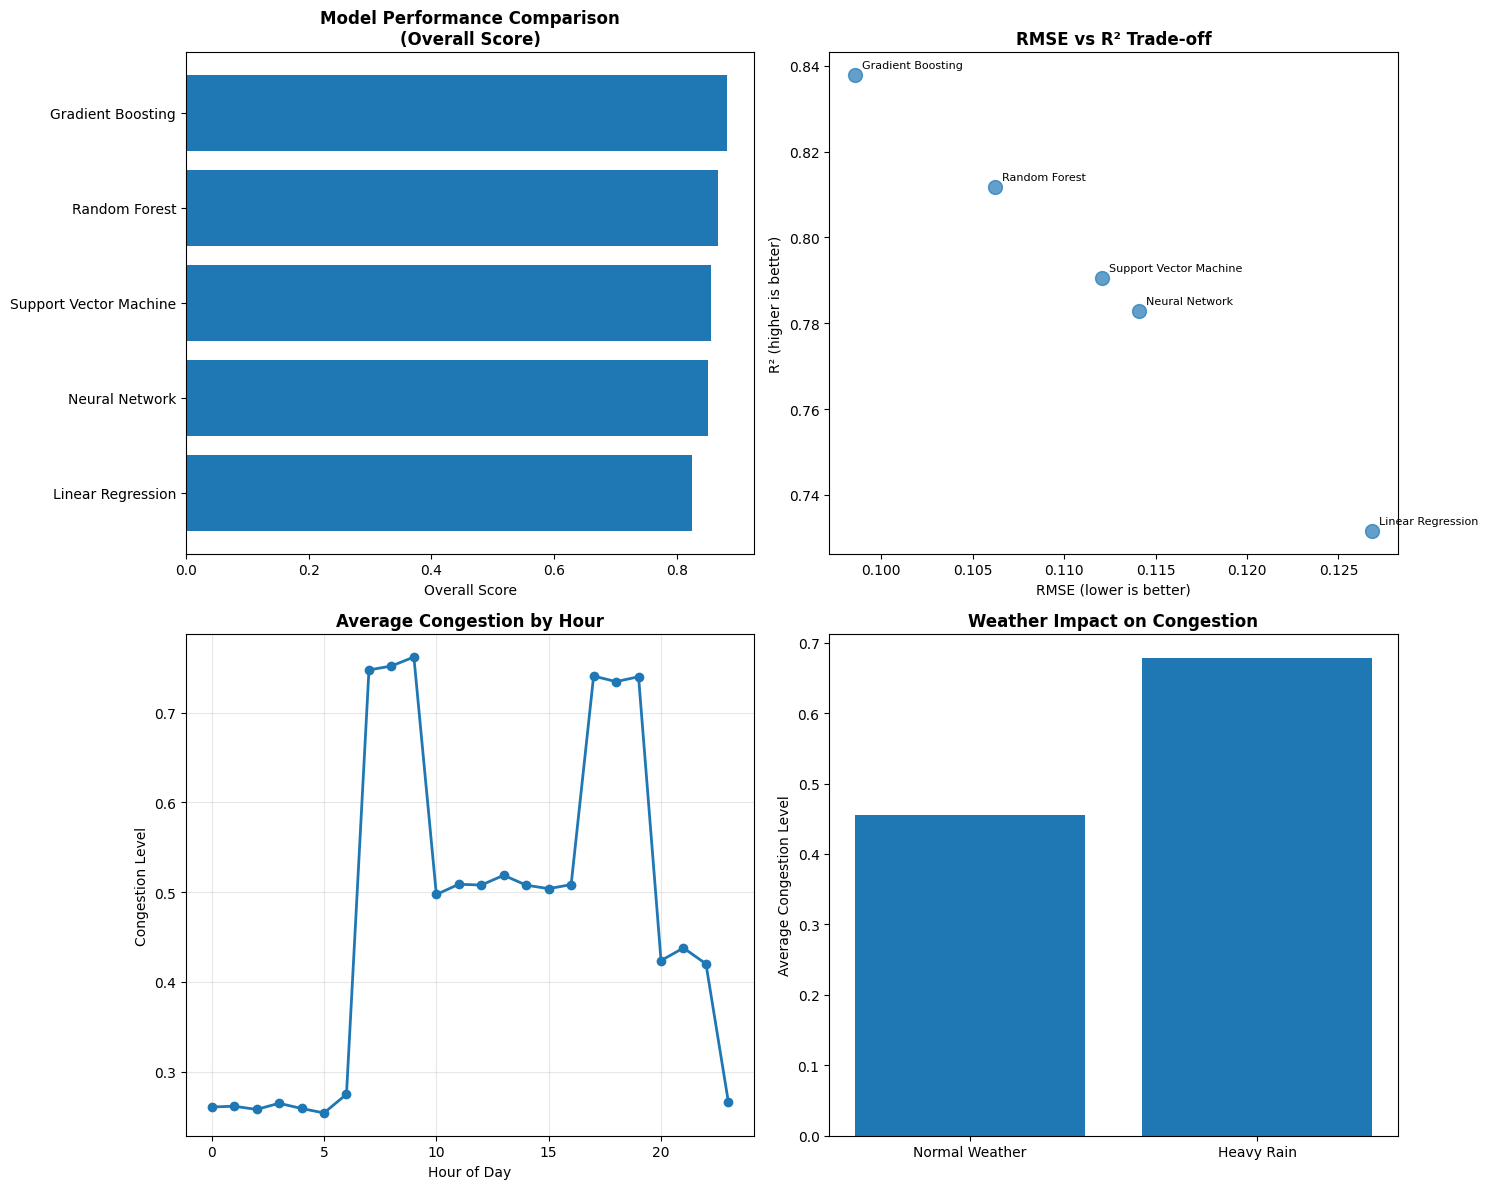

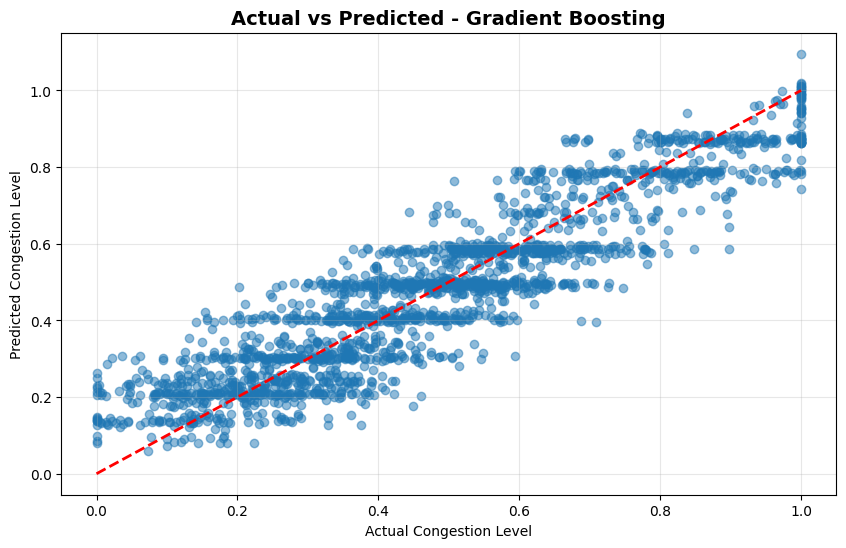


EXAMPLE PREDICTIONS
Tuesday 8 AM, mild weather: 0.765 (using Gradient Boosting)
Tuesday 6 PM, mild weather: 0.750 (using Gradient Boosting)
Tuesday 8 AM, heavy rain: 1.001 (using Gradient Boosting)
Saturday 2 PM, summer: 0.190 (using Gradient Boosting)

Analysis complete! Best model: Gradient Boosting


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class TrafficCongestionModel:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.scaler = StandardScaler()

    def generate_realistic_data(self, n_samples=10000):
        """Generate realistic traffic data based on real-world patterns"""
        print("Generating realistic traffic data...")

        # Time features
        hours = np.random.randint(0, 24, n_samples)
        days_of_week = np.random.randint(0, 7, n_samples)  # 0=Monday, 6=Sunday
        months = np.random.randint(1, 13, n_samples)

        # Weather features
        temperature = np.random.normal(20, 10, n_samples)  # Celsius
        precipitation = np.random.exponential(2, n_samples)  # mm
        wind_speed = np.random.gamma(2, 2, n_samples)  # km/h

        # Create realistic congestion patterns
        congestion_level = np.zeros(n_samples)

        for i in range(n_samples):
            hour = hours[i]
            day = days_of_week[i]
            month = months[i]
            temp = temperature[i]
            rain = precipitation[i]
            wind = wind_speed[i]

            # Base congestion level
            base_level = 0.3

            # Rush hour effects (7-9 AM, 5-7 PM)
            if 7 <= hour <= 9 or 17 <= hour <= 19:
                base_level += 0.5
            elif 10 <= hour <= 16:
                base_level += 0.2
            elif 20 <= hour <= 22:
                base_level += 0.1
            else:
                base_level -= 0.1

            # Weekend effects (less congestion)
            if day >= 5:  # Weekend
                base_level *= 0.6

            # Weather effects
            if rain > 5:  # Heavy rain
                base_level += 0.3
            elif rain > 1:  # Light rain
                base_level += 0.1

            if temp < 0 or temp > 35:  # Extreme temperatures
                base_level += 0.2

            if wind > 20:  # High wind
                base_level += 0.1

            # Holiday/summer effects
            if month in [7, 8, 12]:  # Summer/December
                base_level *= 0.8

            # Add some noise
            noise = np.random.normal(0, 0.1)
            congestion_level[i] = max(0, min(1, base_level + noise))

        # Create DataFrame
        data = pd.DataFrame({
            'hour': hours,
            'day_of_week': days_of_week,
            'month': months,
            'temperature': temperature,
            'precipitation': precipitation,
            'wind_speed': wind_speed,
            'congestion_level': congestion_level
        })

        # Add derived features
        data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
        data['is_rush_hour'] = ((data['hour'].between(7, 9)) |
                               (data['hour'].between(17, 19))).astype(int)
        data['is_business_hour'] = data['hour'].between(9, 17).astype(int)
        data['temp_extreme'] = ((data['temperature'] < 0) |
                               (data['temperature'] > 35)).astype(int)
        data['heavy_rain'] = (data['precipitation'] > 5).astype(int)
        data['high_wind'] = (data['wind_speed'] > 20).astype(int)

        return data

    def prepare_data(self, data):
        """Prepare data for modeling"""
        # Features for modeling
        feature_cols = [
            'hour', 'day_of_week', 'month', 'temperature', 'precipitation',
            'wind_speed', 'is_weekend', 'is_rush_hour', 'is_business_hour',
            'temp_extreme', 'heavy_rain', 'high_wind'
        ]

        X = data[feature_cols]
        y = data['congestion_level']

        return X, y

    def initialize_models(self):
        """Initialize different models for comparison"""
        self.models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'Support Vector Machine': SVR(kernel='rbf', C=1.0, gamma='scale'),
            'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50),
                                         max_iter=500, random_state=42)
        }

    def train_and_evaluate(self, X, y):
        """Train and evaluate all models"""
        print("Training and evaluating models...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features for models that need it
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        results = {}

        for name, model in self.models.items():
            print(f"Training {name}...")

            # Use scaled data for SVM and Neural Network
            if name in ['Support Vector Machine', 'Neural Network']:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                # Cross-validation with scaled data
                cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                          cv=5, scoring='neg_mean_squared_error')
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # Cross-validation with original data
                cv_scores = cross_val_score(model, X_train, y_train,
                                          cv=5, scoring='neg_mean_squared_error')

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            cv_rmse = np.sqrt(-cv_scores.mean())

            # Calculate overall score (weighted combination of metrics)
            # Higher R² is better, lower RMSE/MAE is better
            overall_score = (r2 * 0.4) + ((1 - rmse) * 0.3) + ((1 - mae) * 0.3)

            results[name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'CV_RMSE': cv_rmse,
                'Overall_Score': overall_score,
                'Predictions': y_pred
            }

        self.results = results
        return results

    def display_results(self):
        """Display model comparison results"""
        print("\n" + "="*80)
        print("MODEL COMPARISON RESULTS")
        print("="*80)

        # Create results DataFrame
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.drop('Predictions', axis=1)

        # Sort by overall score (descending)
        results_df = results_df.sort_values('Overall_Score', ascending=False)

        print("\nModel Performance Metrics:")
        print("-" * 80)
        print(f"{'Model':<20} {'RMSE':<8} {'MAE':<8} {'R²':<8} {'CV_RMSE':<8} {'Score':<8}")
        print("-" * 80)

        for model_name, metrics in results_df.iterrows():
            print(f"{model_name:<20} {metrics['RMSE']:<8.4f} {metrics['MAE']:<8.4f} "
                  f"{metrics['R²']:<8.4f} {metrics['CV_RMSE']:<8.4f} {metrics['Overall_Score']:<8.4f}")

        # Find best model
        best_model = results_df.index[0]
        best_score = results_df.iloc[0]['Overall_Score']

        print(f"\n🏆 BEST MODEL: {best_model}")
        print(f"   Overall Score: {best_score:.4f}")
        print(f"   RMSE: {results_df.iloc[0]['RMSE']:.4f}")
        print(f"   R²: {results_df.iloc[0]['R²']:.4f}")

        return results_df

    def plot_results(self, data):
        """Create visualizations of the results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Model Performance Comparison
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.drop('Predictions', axis=1)
        results_df = results_df.sort_values('Overall_Score', ascending=True)

        axes[0, 0].barh(results_df.index, results_df['Overall_Score'])
        axes[0, 0].set_title('Model Performance Comparison\n(Overall Score)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Overall Score')

        # 2. RMSE vs R² scatter
        axes[0, 1].scatter(results_df['RMSE'], results_df['R²'], s=100, alpha=0.7)
        for i, model in enumerate(results_df.index):
            axes[0, 1].annotate(model, (results_df.iloc[i]['RMSE'], results_df.iloc[i]['R²']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[0, 1].set_xlabel('RMSE (lower is better)')
        axes[0, 1].set_ylabel('R² (higher is better)')
        axes[0, 1].set_title('RMSE vs R² Trade-off', fontsize=12, fontweight='bold')

        # 3. Congestion by Hour
        hourly_avg = data.groupby('hour')['congestion_level'].mean()
        axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
        axes[1, 0].set_title('Average Congestion by Hour', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Hour of Day')
        axes[1, 0].set_ylabel('Congestion Level')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Weather Impact
        weather_impact = data.groupby('heavy_rain')['congestion_level'].mean()
        axes[1, 1].bar(['Normal Weather', 'Heavy Rain'], weather_impact.values)
        axes[1, 1].set_title('Weather Impact on Congestion', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Average Congestion Level')

        plt.tight_layout()
        plt.show()

        # Additional plot: Actual vs Predicted for best model
        best_model_name = max(self.results.keys(), key=lambda x: self.results[x]['Overall_Score'])
        best_predictions = self.results[best_model_name]['Predictions']

        # Get test data for comparison
        X, y = self.prepare_data(data)
        _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)[1::2]

        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, best_predictions, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Congestion Level')
        plt.ylabel('Predicted Congestion Level')
        plt.title(f'Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.show()

    def predict_congestion(self, hour, day_of_week, month, temperature, precipitation, wind_speed):
        """Predict congestion for given conditions"""
        best_model_name = max(self.results.keys(), key=lambda x: self.results[x]['Overall_Score'])
        best_model = self.models[best_model_name]

        # Create input data
        input_data = pd.DataFrame({
            'hour': [hour],
            'day_of_week': [day_of_week],
            'month': [month],
            'temperature': [temperature],
            'precipitation': [precipitation],
            'wind_speed': [wind_speed],
            'is_weekend': [1 if day_of_week >= 5 else 0],
            'is_rush_hour': [1 if (7 <= hour <= 9) or (17 <= hour <= 19) else 0],
            'is_business_hour': [1 if 9 <= hour <= 17 else 0],
            'temp_extreme': [1 if temperature < 0 or temperature > 35 else 0],
            'heavy_rain': [1 if precipitation > 5 else 0],
            'high_wind': [1 if wind_speed > 20 else 0]
        })

        # Scale if needed
        if best_model_name in ['Support Vector Machine', 'Neural Network']:
            input_data_scaled = self.scaler.transform(input_data)
            prediction = best_model.predict(input_data_scaled)[0]
        else:
            prediction = best_model.predict(input_data)[0]

        return prediction, best_model_name

# Run the complete analysis
def main():
    print("🚦 TRAFFIC CONGESTION MODELING SYSTEM")
    print("="*50)

    # Initialize the model
    traffic_model = TrafficCongestionModel()

    # Generate realistic data
    data = traffic_model.generate_realistic_data(n_samples=10000)

    # Prepare data
    X, y = traffic_model.prepare_data(data)

    # Initialize models
    traffic_model.initialize_models()

    # Train and evaluate
    results = traffic_model.train_and_evaluate(X, y)

    # Display results
    results_df = traffic_model.display_results()

    # Create visualizations
    traffic_model.plot_results(data)

    # Example predictions
    print("\n" + "="*50)
    print("EXAMPLE PREDICTIONS")
    print("="*50)

    scenarios = [
        (8, 1, 3, 15, 0, 5, "Tuesday 8 AM, mild weather"),
        (18, 1, 3, 15, 0, 5, "Tuesday 6 PM, mild weather"),
        (8, 1, 3, 15, 8, 5, "Tuesday 8 AM, heavy rain"),
        (14, 6, 7, 25, 0, 5, "Saturday 2 PM, summer"),
    ]

    for hour, day, month, temp, rain, wind, description in scenarios:
        prediction, model_name = traffic_model.predict_congestion(
            hour, day, month, temp, rain, wind
        )
        print(f"{description}: {prediction:.3f} (using {model_name})")

    print(f"\nAnalysis complete! Best model: {max(results.keys(), key=lambda x: results[x]['Overall_Score'])}")

if __name__ == "__main__":
    main()